In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
import brainiak
import nilearn as nl
from nilearn import image, plotting, input_data

from scipy.spatial import distance

from utils import *

# load roi

In [2]:
def load_sub_roi(sub_n,roi_name):
  fpath = "sub-%i_%s.npy"%(sub_n,roi_name)
  return np.load('fmri_data/masked/'+fpath)

def load_group_roi(roi_name):
  L = []
  for sub_n in SUB_NS:
    sub_roi = load_sub_roi(sub_n,roi_name)
    print(sub_roi.shape)
    L.append(sub_roi)
  return np.array(L)

for sub_n in SUB_NS:
  roi = load_sub_roi(sub_n,'rsherlockAvg_fc_thr5_pmc')
  print(roi.shape)

(1168, 6170)
(1166, 6170)
(1168, 6170)
(1167, 6170)
(1166, 6170)
(1168, 6170)
(1166, 6170)
(1167, 6170)
(1166, 6170)


# HPC plots

In [80]:
def load_hpc(max_tsteps=1100):
  L = []
  for sub_n in SUB_NS:
    sub_hpc = load_sub_roi(sub_n,ROI_NAME_L[-1])[:max_tsteps,:].mean(1)
    L.append(sub_hpc)
  return np.array(L)

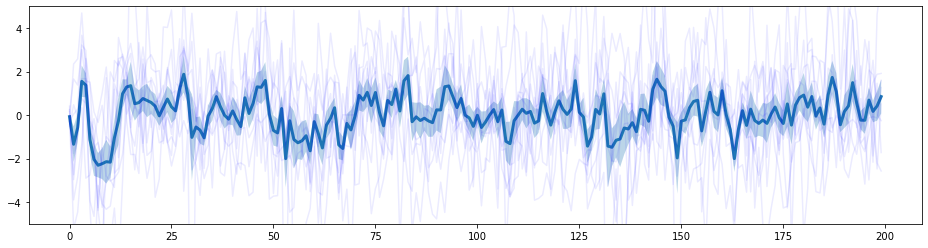

In [100]:
tsteps = 200
group_hpc = load_hpc(max_tsteps=tsteps)
M = group_hpc.mean(0)
S = group_hpc.std(0)/np.sqrt(len(SUB_NS))
# plot
plt.figure(figsize=(16,4))
plt.plot(M,lw=3)
plt.fill_between(range(tsteps),M-S,M+S,alpha=.3)

for sub_hpc in group_hpc:
  plt.plot(sub_hpc,alpha=.08,c='b')

plt.ylim(-5,5)

plt.savefig('figures/meanHPC')

# Time RSA

In [61]:
fig_len = 400
for roi_name in ROI_NAME_L:
  for sub_n in SUB_NS:
    print(roi_name,sub_n)
    sub_roi = load_sub_roi(sub_n,roi_name)[20:fig_len,:]
    # rsa
    cormat = 1-distance.cdist(sub_roi,sub_roi,metric='correlation')
    # plt
    plt.figure(figsize=(50,50))
    ax = plt.gca()
    for pltline in range(0,fig_len,100):
      ax.axvline(pltline,c='k',lw=4)
      ax.axhline(pltline,c='k',lw=4)
    plt.title('%s-sub-%i'%(roi_name,sub_n))
    ax.imshow(cormat,cmap='seismic',vmin=-1,vmax=1)
    plt.savefig('figures/timeRSA/viewingRSA/sub-%i_%s'%(sub_n,roi_name))
    plt.savefig('figures/timeRSA/viewingRSA/%s_sub-%i'%(roi_name.split('-')[-1],sub_n))
    plt.close('all')


rsherlockAvg_fc_thr5_rTPJ 30
rsherlockAvg_fc_thr5_rTPJ 31
rsherlockAvg_fc_thr5_rTPJ 32
rsherlockAvg_fc_thr5_rTPJ 33
rsherlockAvg_fc_thr5_rTPJ 34
rsherlockAvg_fc_thr5_rTPJ 35
rsherlockAvg_fc_thr5_rTPJ 36
rsherlockAvg_fc_thr5_rTPJ 37
rsherlockAvg_fc_thr5_rTPJ 38
rsherlockAvg_fc_thr5_pmc 30
rsherlockAvg_fc_thr5_pmc 31
rsherlockAvg_fc_thr5_pmc 32
rsherlockAvg_fc_thr5_pmc 33
rsherlockAvg_fc_thr5_pmc 34
rsherlockAvg_fc_thr5_pmc 35
rsherlockAvg_fc_thr5_pmc 36
rsherlockAvg_fc_thr5_pmc 37
rsherlockAvg_fc_thr5_pmc 38
rsherlockAvg_fc_thr5_rSFG 30
rsherlockAvg_fc_thr5_rSFG 31
rsherlockAvg_fc_thr5_rSFG 32
rsherlockAvg_fc_thr5_rSFG 33
rsherlockAvg_fc_thr5_rSFG 34
rsherlockAvg_fc_thr5_rSFG 35
rsherlockAvg_fc_thr5_rSFG 36
rsherlockAvg_fc_thr5_rSFG 37
rsherlockAvg_fc_thr5_rSFG 38
rsherlockAvg_fc_thr5_lSFG 30
rsherlockAvg_fc_thr5_lSFG 31
rsherlockAvg_fc_thr5_lSFG 32
rsherlockAvg_fc_thr5_lSFG 33
rsherlockAvg_fc_thr5_lSFG 34
rsherlockAvg_fc_thr5_lSFG 35
rsherlockAvg_fc_thr5_lSFG 36
rsherlockAvg_fc_thr5_lS